# 1. Making classification data

In [1]:
import numpy as np
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000
X, y = make_circles(n_samples=n_samples, random_state=42, noise=0.03)

In [3]:
X[:10], y[:10]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343],
        [-0.47964637,  0.67643477],
        [-0.01364836,  0.80334872],
        [ 0.77151327,  0.14775959],
        [-0.16932234, -0.79345575],
        [-0.1214858 ,  1.02150905]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [4]:
np.unique(y)

array([0, 1])

In [5]:
import pandas as pd
circles = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'labels': y
})
circles.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


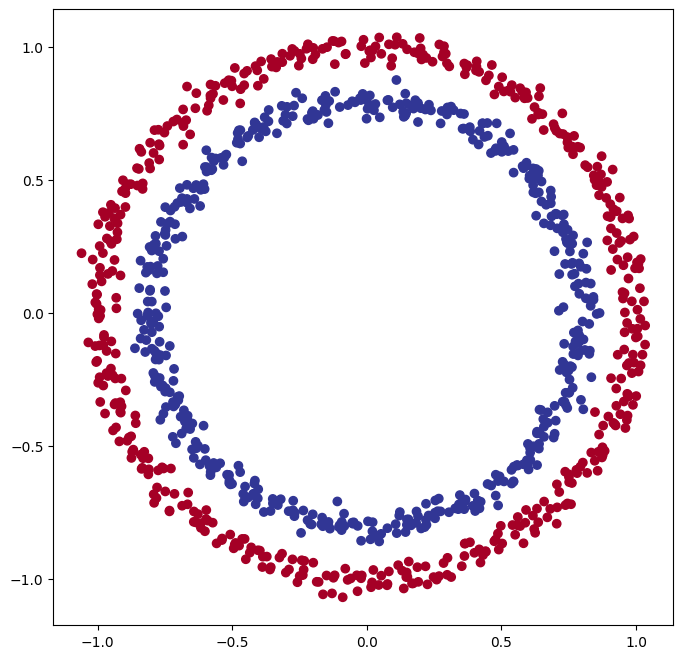

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show();

## Input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

## Turn into tensors and create train test split

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building a model

In [10]:
import torch
from torch import nn, dtype

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device, torch.__version__

('mps', '2.9.1')

In [11]:
class CircleNetV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

In [12]:
model_test = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_test.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
pew = model_test(X_train[:4].to(device))
print(pew)

tensor([[-0.3046],
        [-0.2249],
        [-0.4422],
        [-0.4110]], device='mps:0', grad_fn=<LinearBackward0>)


In [14]:
loss= nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_test.parameters(), lr=0.01)


In [15]:
model_0 = CircleNetV0().to(device)
model_0

CircleNetV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
untrained_preds = model_0(X_test.to(device))

In [18]:
print(f'First 10 predictions: {untrained_preds[:10]}')

First 10 predictions: tensor([[0.1147],
        [0.1550],
        [0.0283],
        [0.1391],
        [0.0585],
        [0.0829],
        [0.1722],
        [0.1554],
        [0.0271],
        [0.1580]], device='mps:0', grad_fn=<SliceBackward0>)


In [19]:
## Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [20]:
## Evaluation Metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

In [21]:
## Let's use sample model prediction to see how it works
y_logits = model_0(X_test[:5].to(device))
print(y_logits)

tensor([[0.1147],
        [0.1550],
        [0.0283],
        [0.1391],
        [0.0585]], device='mps:0', grad_fn=<LinearBackward0>)


In [22]:
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.5287],
        [0.5387],
        [0.5071],
        [0.5347],
        [0.5146]], device='mps:0', grad_fn=<SigmoidBackward0>)


In [23]:
y_preds = torch.round(y_pred_probs)
print(y_preds)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0', grad_fn=<RoundBackward0>)


In [24]:
print(y_preds.squeeze())

tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)


In [25]:
# Oneliner approach
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

In [26]:
print(y_pred_labels.squeeze())

tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)


## Building Training and Testing Loop

In [27]:
torch.manual_seed(42)

# Number of epochs
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Put in training mode
    model_0.train()
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # Since we are Using BCEWithLogitsLoss
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Eval mode
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss: {loss:.4f}, accuracy: {accuracy:.4f} | Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Epoch 0, loss: 0.6940, accuracy: 51.3750 | Test loss: 0.6966, Test accuracy: 50.5000
Epoch 10, loss: 0.6939, accuracy: 54.2500 | Test loss: 0.6966, Test accuracy: 53.5000
Epoch 20, loss: 0.6938, accuracy: 57.2500 | Test loss: 0.6965, Test accuracy: 56.5000
Epoch 30, loss: 0.6938, accuracy: 58.3750 | Test loss: 0.6965, Test accuracy: 58.0000
Epoch 40, loss: 0.6937, accuracy: 59.5000 | Test loss: 0.6964, Test accuracy: 57.0000
Epoch 50, loss: 0.6936, accuracy: 58.2500 | Test loss: 0.6964, Test accuracy: 54.5000
Epoch 60, loss: 0.6936, accuracy: 56.8750 | Test loss: 0.6963, Test accuracy: 53.0000
Epoch 70, loss: 0.6936, accuracy: 55.8750 | Test loss: 0.6963, Test accuracy: 53.5000
Epoch 80, loss: 0.6935, accuracy: 55.7500 | Test loss: 0.6962, Test accuracy: 51.5000
Epoch 90, loss: 0.6935, accuracy: 55.1250 | Test loss: 0.6962, Test accuracy: 50.0000


In [28]:
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None: plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

In [29]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

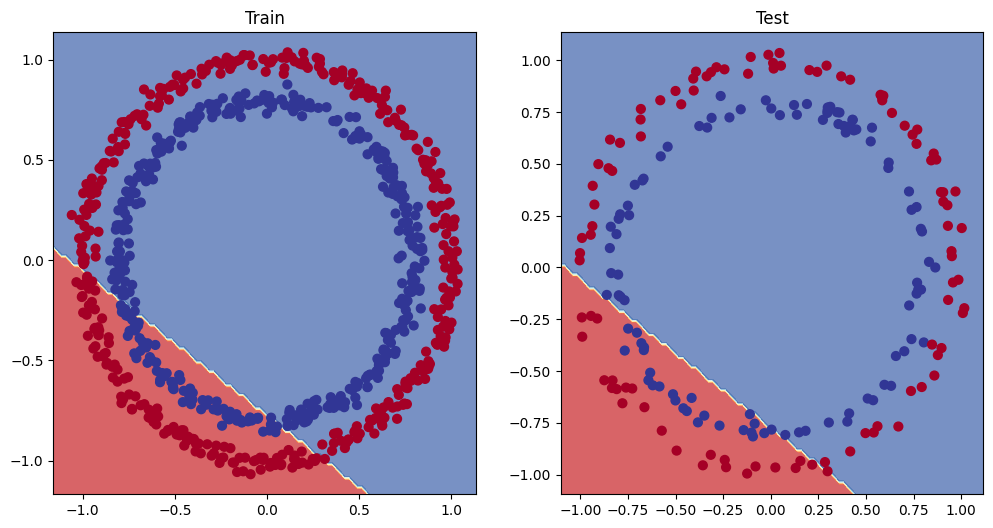

In [30]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [31]:
# Define Another Model
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
)
model_1.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [33]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


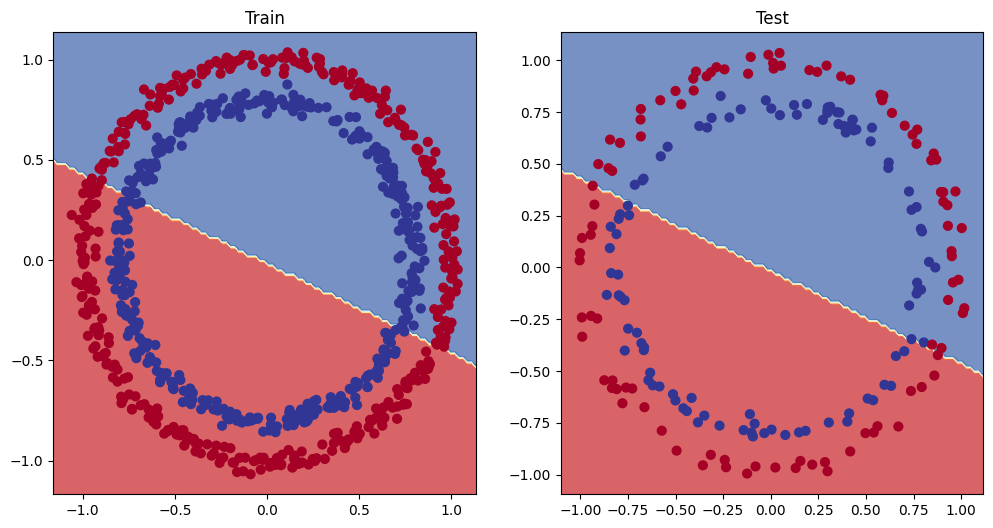

In [34]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [35]:
## Building Non Linear Model
model_3 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
)
model_3.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [37]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [38]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

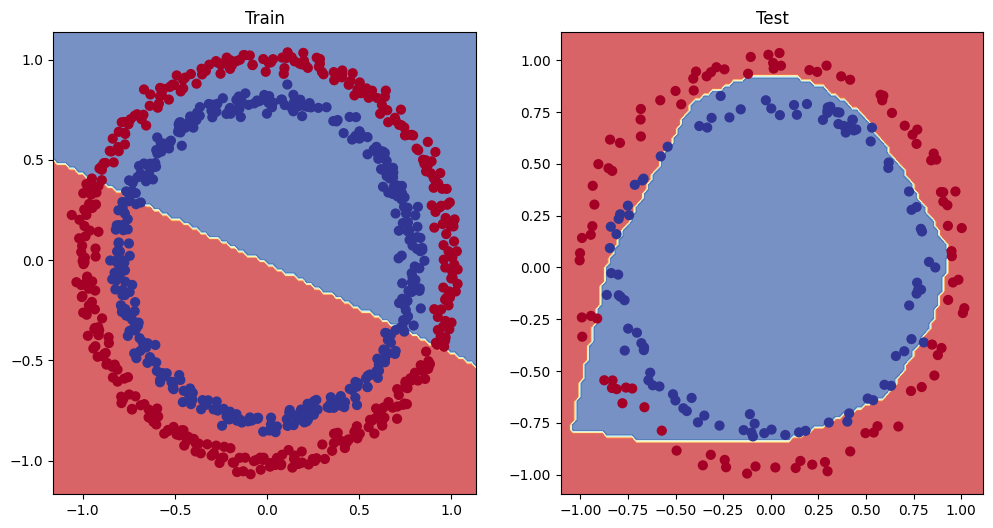

In [39]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Putting together everything by Building a Multi-class PyTorch model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


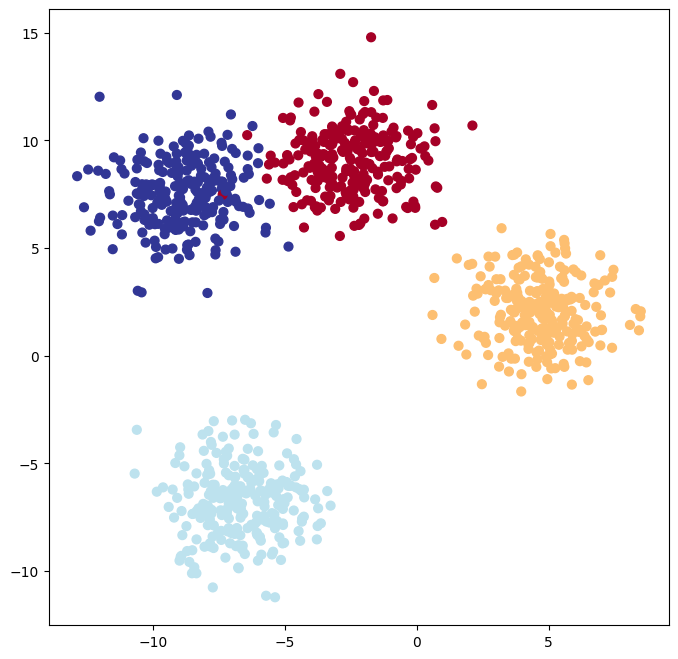

In [40]:
# Importing dependencies
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# data creation hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create a multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)
plt.figure(figsize=(8,8))
plt.scatter(X_blob[:, 0], X_blob[:,1], c=y_blob, s=40, cmap=plt.cm.RdYlBu);

In [41]:
# Create device-agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [42]:
# Building the model
class BlobModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.linear_stack_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units, bias=True),
            #nn.ReLU(), # Why Relu ?
            nn.Linear(in_features=hidden_units, out_features=hidden_units, bias=True),
            #nn.ReLU(), # Also here, tested the performance and they almost the same
            nn.Linear(in_features=hidden_units, out_features=out_features, bias=True),
        )

    def forward(self, x):
        return self.linear_stack_layer(x)

In [43]:
model_4 = BlobModel(in_features=NUM_FEATURES, out_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [44]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [45]:
pew = model_4(X_blob_train.to(device))

In [46]:
print(pew[:5])

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [47]:
pew.shape[1], NUM_CLASSES

(4, 4)

## We have to go from logit -> prediction probabilities -> prediction labels

In [48]:
# We are going to use softmax function for our classes
y_logits = model_4(X_blob_train.to(device))
# Perform softmax calculation on logits across dim 1 / columns
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        [0.3405, 0.0657, 0.4446, 0.1492],
        [0.2527, 0.0424, 0.2283, 0.4766]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [49]:
# What this means is
torch.sum(y_pred_probs[0]) # It should print 1

tensor(1.0000, device='mps:0', grad_fn=<SumBackward0>)

> Basically we are putting the probability distribution for classes

In [50]:
print(y_pred_probs[0])
print(f'The maximum : {torch.argmax(y_pred_probs[0])}')

tensor([0.1838, 0.3422, 0.1500, 0.3239], device='mps:0',
       grad_fn=<SelectBackward0>)
The maximum : 1


## Training and testing

In [51]:
torch.manual_seed(42)
epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_accuracy = accuracy_fn(y_true=y_blob_test,y_pred=test_pred)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Training Loss: {loss:.5f}, Training Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.5f}')

Epoch: 0 | Training Loss: 1.04324, Training Accuracy: 65.50% | Test Loss: 0.57861, Test Accuracy: 95.50000
Epoch: 100 | Training Loss: 0.03185, Training Accuracy: 99.12% | Test Loss: 0.02293, Test Accuracy: 99.50000
Epoch: 200 | Training Loss: 0.02707, Training Accuracy: 99.12% | Test Loss: 0.01704, Test Accuracy: 99.50000
Epoch: 300 | Training Loss: 0.02564, Training Accuracy: 99.25% | Test Loss: 0.01499, Test Accuracy: 99.50000
Epoch: 400 | Training Loss: 0.02492, Training Accuracy: 99.25% | Test Loss: 0.01389, Test Accuracy: 99.50000
Epoch: 500 | Training Loss: 0.02444, Training Accuracy: 99.25% | Test Loss: 0.01318, Test Accuracy: 99.50000
Epoch: 600 | Training Loss: 0.02407, Training Accuracy: 99.25% | Test Loss: 0.01265, Test Accuracy: 99.50000
Epoch: 700 | Training Loss: 0.02377, Training Accuracy: 99.25% | Test Loss: 0.01224, Test Accuracy: 99.50000
Epoch: 800 | Training Loss: 0.02349, Training Accuracy: 99.25% | Test Loss: 0.01190, Test Accuracy: 99.50000
Epoch: 900 | Training

In [52]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
print(y_logits[:10])

tensor([[  6.1116,  18.9108, -22.9636, -14.6997],
        [  9.5666, -23.8505,   5.8415,  17.7030],
        [ -8.4024, -21.8532,  30.5471,  17.0859],
        [  2.1339,  14.6656, -13.7831, -11.2654],
        [ 13.2143,   3.9344, -21.4955,  -3.6478],
        [ 10.8396, -29.6211,   8.5484,  22.0351],
        [ -9.3843, -15.7083,  27.1178,  12.4539],
        [ 11.9277,  -3.3287, -13.8624,   1.9501],
        [ -7.8684, -31.8191,  37.6571,  24.6512],
        [ 12.1834,  -0.6223, -16.3794,  -0.1245]], device='mps:0')


In [53]:
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
print(f'Predictions: {y_preds[:10]}')
print(f'Original Labels: {y_blob_test[:10]}')

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Original Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')


In [54]:
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Test accuracy: 99.5%


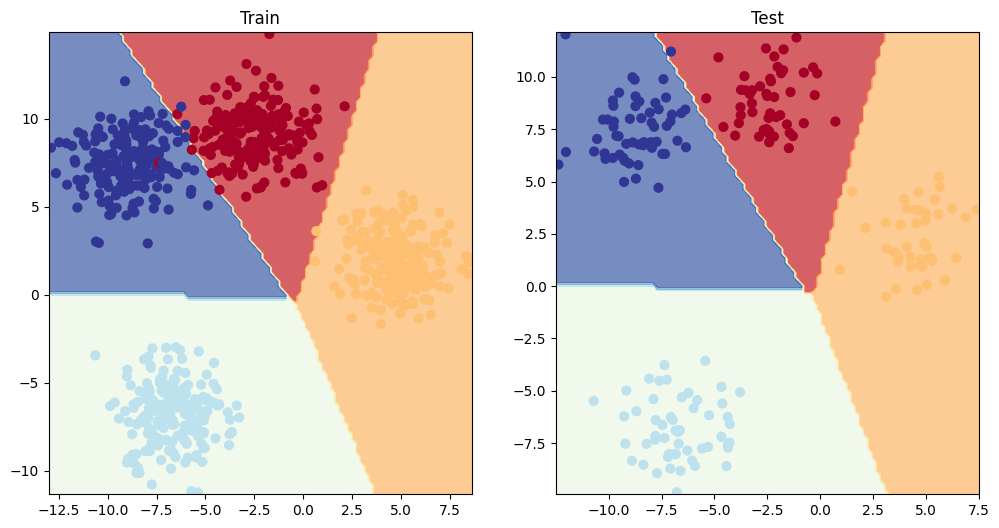

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [57]:
model_4

BlobModel(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [58]:
param_size = 0
buffer_size = 0
for param in model_4.parameters():
    param_size += param.nelement() * param.element_size()
for buffer in model_4.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
total_size = (param_size + buffer_size) / 1024**2
print(f'Model size: {total_size:.3f} MB')

Model size: 0.001 MB


In [60]:
model_4.buffers

<bound method Module.buffers of BlobModel(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)>

In [62]:
[ param.dtype for param in model_4.parameters()]

[torch.float32,
 torch.float32,
 torch.float32,
 torch.float32,
 torch.float32,
 torch.float32]

In [73]:
from torch.quantization import quantize_dynamic
torch.backends.quantized.engine = 'qnnpack'
model_4.eval()
quantized_model = quantize_dynamic(
    model_4,
    {nn.Linear},
    dtype=torch.qint8
)

/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_35832/3348683261.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = quantize_dynamic(


In [74]:
quantized_model

BlobModel(
  (linear_stack_layer): Sequential(
    (0): DynamicQuantizedLinear(in_features=2, out_features=8, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (1): DynamicQuantizedLinear(in_features=8, out_features=8, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (2): DynamicQuantizedLinear(in_features=8, out_features=4, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  )
)

In [75]:
param_size = 0
buffer_size = 0
for param in quantized_model.parameters():
    param_size += param.nelement() * param.element_size()
for buffer in quantized_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
total_size = (param_size + buffer_size) / 1024**2
print(f'Model size: {total_size:.3f} MB')

Model size: 0.000 MB
